# Clustering

In this notebook I cluster the sign distributions.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import copy

from sklearn.cluster import SpectralClustering, KMeans, AgglomerativeClustering

get collective sign distributions:

In [2]:
# load one collective sign distribution
def get_collective_sign_distr(n, name, layer):

    # collect all the sign distributions in one huge dataFrame
    coll_sign_distr = pd.DataFrame()
    for i in range(n):
        sign_distr = pd.read_csv(f'2b Sign distributions/{name}_{i}_sign_distr.csv')
        coll_sign_distr = pd.concat([coll_sign_distr, sign_distr])
    # seperate the dataframe by layer
    coll_sign_distr = coll_sign_distr[coll_sign_distr["layer"]==layer][["prune_rate_in", "prune_rate_out", "sign_rate_in", "sign_rate_out"]]
    
    return coll_sign_distr

perform clustering:

In [3]:
def cluster_sign_distr(sign_distr, n_clusters = 4, algorithm = AgglomerativeClustering, print_matrix = False):

    sign_distr = copy.copy(sign_distr)
    
    # preprocess the data
    sign_distr_array = []
    for index, row in sign_distr.iterrows():
        sign_distr_array.append(row.to_numpy())
    sign_distr_array = np.array(sign_distr_array)
    
    # clustering
    clustering = algorithm(n_clusters=n_clusters)
    clustering.fit(sign_distr_array)
    labels = clustering.labels_
    
    # append labels to dataframe
    labels_df = pd.DataFrame(labels, index=range(len(labels)),columns=["cluster"])
    sign_distr = sign_distr.reset_index(drop=True)
    sign_distr = pd.concat([sign_distr, labels_df], axis=1)
    
    # show scatterplot matrix
    if print_matrix:
        sns.pairplot(sign_distr, hue="cluster", height=1.75, kind='scatter', plot_kws={'alpha':0.8})
    
    return sign_distr

store the clustered scatterplots

/net/projects/scratch/summer/valid_until_31_January_2025/epetersen/miniconda3/envs/thesis/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/net/projects/scratch/summer/valid_until_31_January_2025/epetersen/miniconda3/envs/thesis/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/net/projects/scratch/summer/valid_until_31_January_2025/epetersen/miniconda3/envs/thesis/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before 

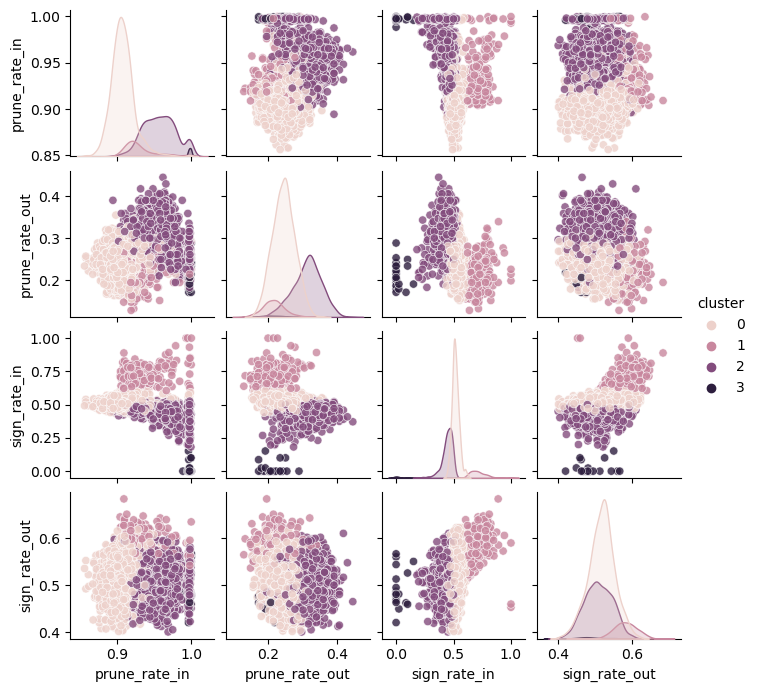

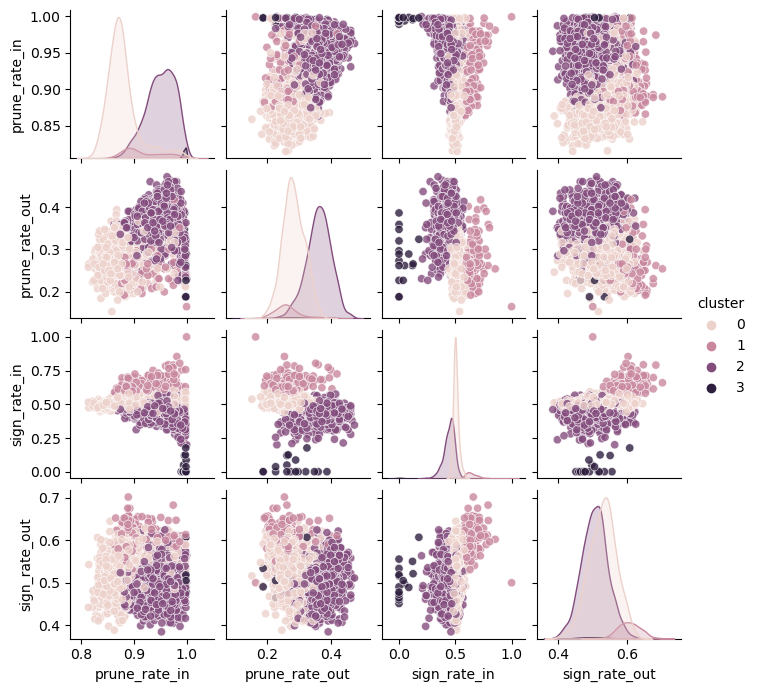

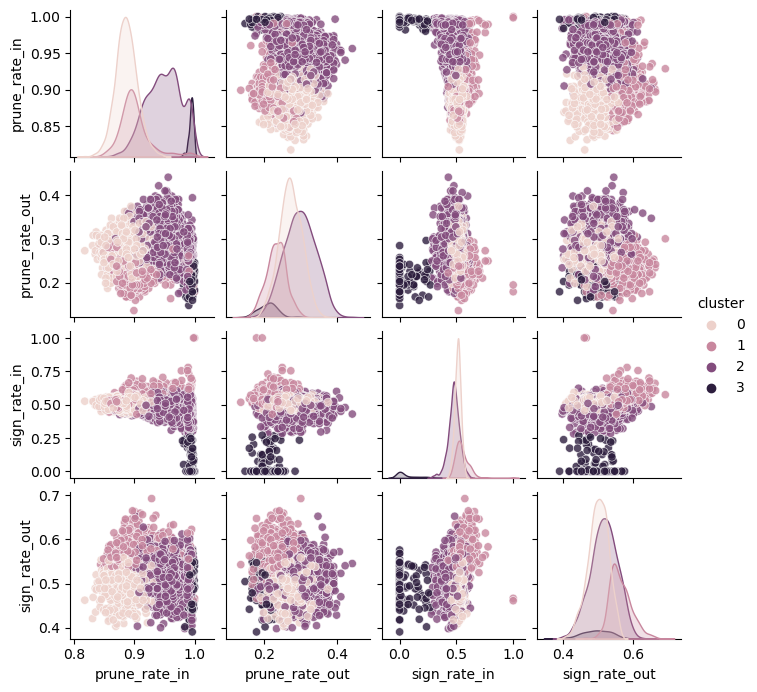

In [4]:
def store_clustered_sign_distr(dataset_names, layer, n_wts, n_clusters):

    for d_name in dataset_names:

        # get the collective sign distributions and cluster them
        coll_sign_distr = get_collective_sign_distr(n_wts, f"{d_name}_IMP",layer)
        clustered_sign_distr = cluster_sign_distr(coll_sign_distr, n_clusters=n_clusters, algorithm=AgglomerativeClustering)

        # relabel tha cluster uniformly
        labels = clustered_sign_distr[["cluster"]]
        copy_labels = copy.copy(labels)
        if d_name == "CINIC":
            copy_labels[labels["cluster"] == 0] = 2 # make 0 2
            copy_labels[labels["cluster"] == 1] = 0 # make 1 0
            copy_labels[labels["cluster"] == 2] = 1 # make 2 1
        elif d_name == "SVHN":
            copy_labels[labels["cluster"] == 0] = 2# make 0 2
            copy_labels[labels["cluster"] == 1] = 3 # make 1 3
            copy_labels[labels["cluster"] == 2] = 1 # make 2 1
            copy_labels[labels["cluster"] == 3] = 0 # make 3 0
        clustered_sign_distr["cluster"] = copy_labels

        # store the clustered scatterplot
        sns.pairplot(clustered_sign_distr, hue="cluster", height=1.75, kind='scatter', plot_kws={'alpha':0.8}).savefig(f"5b Clusters/clustered({n_clusters})_coll_sign_distr_{d_name}_{layer}.png")

store_clustered_sign_distr(["CIFAR","CINIC","SVHN"], "dense1", 15, 4)

## Cluster Statistics

Collecting mean and std for the different dimensions of each cluster as well as the ratio of neurons belonging to the cluster:

In [5]:
variables = ["prune_rate_in","prune_rate_out","sign_rate_in","sign_rate_out"]
datasets = ["CIFAR_IMP", "CINIC_IMP", "SVHN_IMP"]
n_clusters = [4,4,4]

# make a plot with mean and std of each cluster
all_cluster_stats = []
for dataset, n in zip(datasets,n_clusters):
    
    coll_sign_distr = get_collective_sign_distr(15, dataset,"dense1")
    cluster_data = cluster_sign_distr(coll_sign_distr, n_clusters=n, algorithm=AgglomerativeClustering)

    # relabel tha cluster uniformly
    labels = cluster_data[["cluster"]]
    copy_labels = copy.copy(labels)
    if dataset == "CINIC_IMP":
        copy_labels[labels["cluster"] == 0] = 2 # make 0 2
        copy_labels[labels["cluster"] == 1] = 0 # make 1 0
        copy_labels[labels["cluster"] == 2] = 1 # make 2 1
    elif dataset == "SVHN_IMP":
        copy_labels[labels["cluster"] == 0] = 2# make 0 2
        copy_labels[labels["cluster"] == 1] = 3 # make 1 3
        copy_labels[labels["cluster"] == 2] = 1 # make 2 1
        copy_labels[labels["cluster"] == 3] = 0 # make 3 0
    cluster_data["cluster"] = copy_labels

    cluster_stats = pd.DataFrame()
    for cluster in range(n):

        cluster_stats_block = pd.DataFrame()
        for v in variables:

            cluster_data_filtered = cluster_data[cluster_data["cluster"]==cluster]
            #display(cluster_data_filtered)
            cluster_data_filtered = cluster_data_filtered[v]

            cluster_stats_vrow = {}
            cluster_stats_vrow[f"mean_c{cluster}"] = np.mean(cluster_data_filtered)
            cluster_stats_vrow[f"std_c{cluster}"] = np.std(cluster_data_filtered)
            cluster_stats_vrow[f"ratio_c{cluster}"] = len(cluster_data_filtered)/len(cluster_data[v])

            cluster_stats_vrow_df = pd.DataFrame(cluster_stats_vrow, index=[v])
            cluster_stats_block = pd.concat([cluster_stats_block, cluster_stats_vrow_df], axis=0)

        cluster_stats = pd.concat([cluster_stats, cluster_stats_block], axis=1)

    all_cluster_stats.append(cluster_stats)

for i, cluster_stats in enumerate(all_cluster_stats):
    print(f"Cluster stats for dataset {datasets[i]} with {n_clusters[i]} clusters:")
    display(cluster_stats)

Cluster stats for dataset CIFAR_IMP with 4 clusters:


,mean_c0,std_c0,ratio_c0,mean_c1,std_c1,ratio_c1,mean_c2,std_c2,ratio_c2,mean_c3,std_c3,ratio_c3
prune_rate_in,0.907077,0.015902,0.603369,0.931246,0.022358,0.072263,0.957061,0.021662,0.31812,0.997360,0.002432,0.006248
prune_rate_out,0.243714,0.032519,0.603369,0.216033,0.033270,0.072263,0.312333,0.041503,0.31812,0.213825,0.029214,0.006248
sign_rate_in,0.515617,0.031333,0.603369,0.713277,0.069512,0.072263,0.443338,0.049629,0.31812,0.021103,0.042366,0.006248
sign_rate_out,0.516873,0.035633,0.603369,0.582289,0.031291,0.072263,0.508744,0.037533,0.31812,0.490324,0.036168,0.006248


Cluster stats for dataset CINIC_IMP with 4 clusters:


,mean_c0,std_c0,ratio_c0,mean_c1,std_c1,ratio_c1,mean_c2,std_c2,ratio_c2,mean_c3,std_c3,ratio_c3
prune_rate_in,0.878969,0.031439,0.497503,0.918800,0.036552,0.050562,0.950069,0.026984,0.446629,0.995735,0.002612,0.005306
prune_rate_out,0.281586,0.034332,0.497503,0.265070,0.043985,0.050562,0.360188,0.038953,0.446629,0.280331,0.054433,0.005306
sign_rate_in,0.504505,0.024792,0.497503,0.650593,0.059186,0.050562,0.443026,0.051328,0.446629,0.034998,0.055162,0.005306
sign_rate_out,0.527546,0.040194,0.497503,0.605036,0.031804,0.050562,0.505398,0.037836,0.446629,0.504834,0.039380,0.005306


Cluster stats for dataset SVHN_IMP with 4 clusters:


,mean_c0,std_c0,ratio_c0,mean_c1,std_c1,ratio_c1,mean_c2,std_c2,ratio_c2,mean_c3,std_c3,ratio_c3
prune_rate_in,0.886255,0.017995,0.370436,0.900448,0.026054,0.180766,0.948625,0.028461,0.416741,0.994037,0.003930,0.032057
prune_rate_out,0.272173,0.030839,0.370436,0.232925,0.026981,0.180766,0.298121,0.042472,0.416741,0.210106,0.025332,0.032057
sign_rate_in,0.510626,0.027064,0.370436,0.547191,0.059310,0.180766,0.475291,0.051401,0.416741,0.058045,0.085782,0.032057
sign_rate_out,0.499933,0.028959,0.370436,0.563745,0.031149,0.180766,0.516945,0.038506,0.416741,0.495647,0.038407,0.032057


## Observations

Summarizing the properties of the clusters for each dataset:

In [6]:
for i, cluster_stats in enumerate(all_cluster_stats):

    
    cluster_rows = pd.DataFrame()

    # collect all means
    means = cluster_stats[["mean_c0","mean_c1","mean_c2","mean_c3"]]
    means_p_in = list(means.loc["prune_rate_in"])
    means_p_out = list(means.loc["prune_rate_out"])
    means_s_in = list(means.loc["sign_rate_in"])
    means_s_out = list(means.loc["sign_rate_out"])

    for cluster in range(4):
        cluster_obs = {}

        # for prune in and prune out check whether, highest, lowest or medium
        mean_p_in = cluster_stats.loc["prune_rate_in"][f"mean_c{cluster}"]
        if mean_p_in == np.max(means_p_in):
            cluster_obs["prune_rate_in"] = "highest"
        elif mean_p_in == np.min(means_p_in):
            cluster_obs["prune_rate_in"] = "lowest"
        else:
            cluster_obs["prune_rate_in"] = "medium"
        cluster_obs["prune_rate_in"] = cluster_obs["prune_rate_in"] + f"({np.round(mean_p_in,2)})"

        mean_p_out = cluster_stats.loc["prune_rate_out"][f"mean_c{cluster}"]
        if mean_p_out == np.max(means_p_out):
            cluster_obs["prune_rate_out"] = "highest"
        elif mean_p_out == np.min(means_p_out):
            cluster_obs["prune_rate_out"] = "lowest"
        else:
            cluster_obs["prune_rate_out"] = "medium"
        cluster_obs["prune_rate_out"] = cluster_obs["prune_rate_out"] + f"({np.round(mean_p_out,2)})"

        # for sign in and out check whether balanced, positive or negative
        mean_s_in = cluster_stats.loc["sign_rate_in"][f"mean_c{cluster}"]
        if mean_s_in > 0.55:
            cluster_obs["sign_rate_in"] = "positive"
        elif mean_s_in < 0.45:
            cluster_obs["sign_rate_in"] = "negative"
        else:
            cluster_obs["sign_rate_in"] = "balanced"
        cluster_obs["sign_rate_in"] = cluster_obs["sign_rate_in"] + f"({np.round(mean_s_in,2)})"

        mean_s_out = cluster_stats.loc["sign_rate_out"][f"mean_c{cluster}"]
        if mean_s_out > 0.55:
            cluster_obs["sign_rate_out"] = "positive"
        elif mean_s_out < 0.45:
            cluster_obs["sign_rate_out"] = "negative"
        else:
            cluster_obs["sign_rate_out"] = "balanced"
        cluster_obs["sign_rate_out"] = cluster_obs["sign_rate_out"] + f"({np.round(mean_s_out,2)})"

        # enter the ratio of neurons
        cluster_obs["ratio"] = np.round(cluster_stats.loc["prune_rate_in"][f"ratio_c{cluster}"],2)

        # collect rows in dataframe
        cluster_row = pd.DataFrame(cluster_obs, index=[f"cluster_{cluster}"])
        cluster_rows = pd.concat([cluster_rows, cluster_row], axis=0)
        
    cluster_rows.index = ["cluster_0","cluster_1","cluster_2","cluster_3"]
    cluster_rows = cluster_rows.sort_values("ratio",ascending=False)
    print(f"Cluster stats for dataset {datasets[i]} with {n_clusters[i]} clusters:")
    display(cluster_rows)


Cluster stats for dataset CIFAR_IMP with 4 clusters:


,prune_rate_in,prune_rate_out,sign_rate_in,sign_rate_out,ratio
cluster_0,lowest(0.91),medium(0.24),balanced(0.52),balanced(0.52),0.60
cluster_2,medium(0.96),highest(0.31),negative(0.44),balanced(0.51),0.32
cluster_1,medium(0.93),medium(0.22),positive(0.71),positive(0.58),0.07
cluster_3,highest(1.0),lowest(0.21),negative(0.02),balanced(0.49),0.01


Cluster stats for dataset CINIC_IMP with 4 clusters:


,prune_rate_in,prune_rate_out,sign_rate_in,sign_rate_out,ratio
cluster_0,lowest(0.88),medium(0.28),balanced(0.5),balanced(0.53),0.50
cluster_2,medium(0.95),highest(0.36),negative(0.44),balanced(0.51),0.45
cluster_1,medium(0.92),lowest(0.27),positive(0.65),positive(0.61),0.05
cluster_3,highest(1.0),medium(0.28),negative(0.03),balanced(0.5),0.01


Cluster stats for dataset SVHN_IMP with 4 clusters:


,prune_rate_in,prune_rate_out,sign_rate_in,sign_rate_out,ratio
cluster_2,medium(0.95),highest(0.3),balanced(0.48),balanced(0.52),0.42
cluster_0,lowest(0.89),medium(0.27),balanced(0.51),balanced(0.5),0.37
cluster_1,medium(0.9),medium(0.23),balanced(0.55),positive(0.56),0.18
cluster_3,highest(0.99),lowest(0.21),negative(0.06),balanced(0.5),0.03
